# Продвинутая визуализация данных. Задания 4 (vo_HW)

In [3]:
# %pip install pyod

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from pyod.models.hbos import HBOS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from itertools import combinations
import random
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score

In [5]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(3)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856


In [6]:
weight_height.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


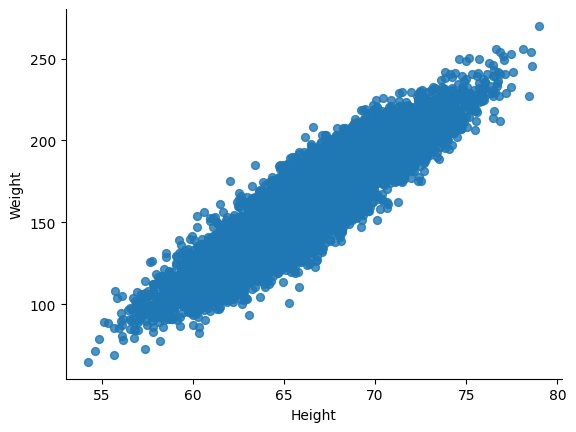

In [7]:
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Задание 1. Сравнение моделей обучения с учителем (4 балла)
Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

    Interquartile range (IQR) — возьмите выбросы по x и y.
    Isolation forest.
    Local Outlier Factor.
    One-class SVM.
    Gaussian Mixture.
    DBSCAN.
Напишите, какие модели показали себя лучше всего и почему.

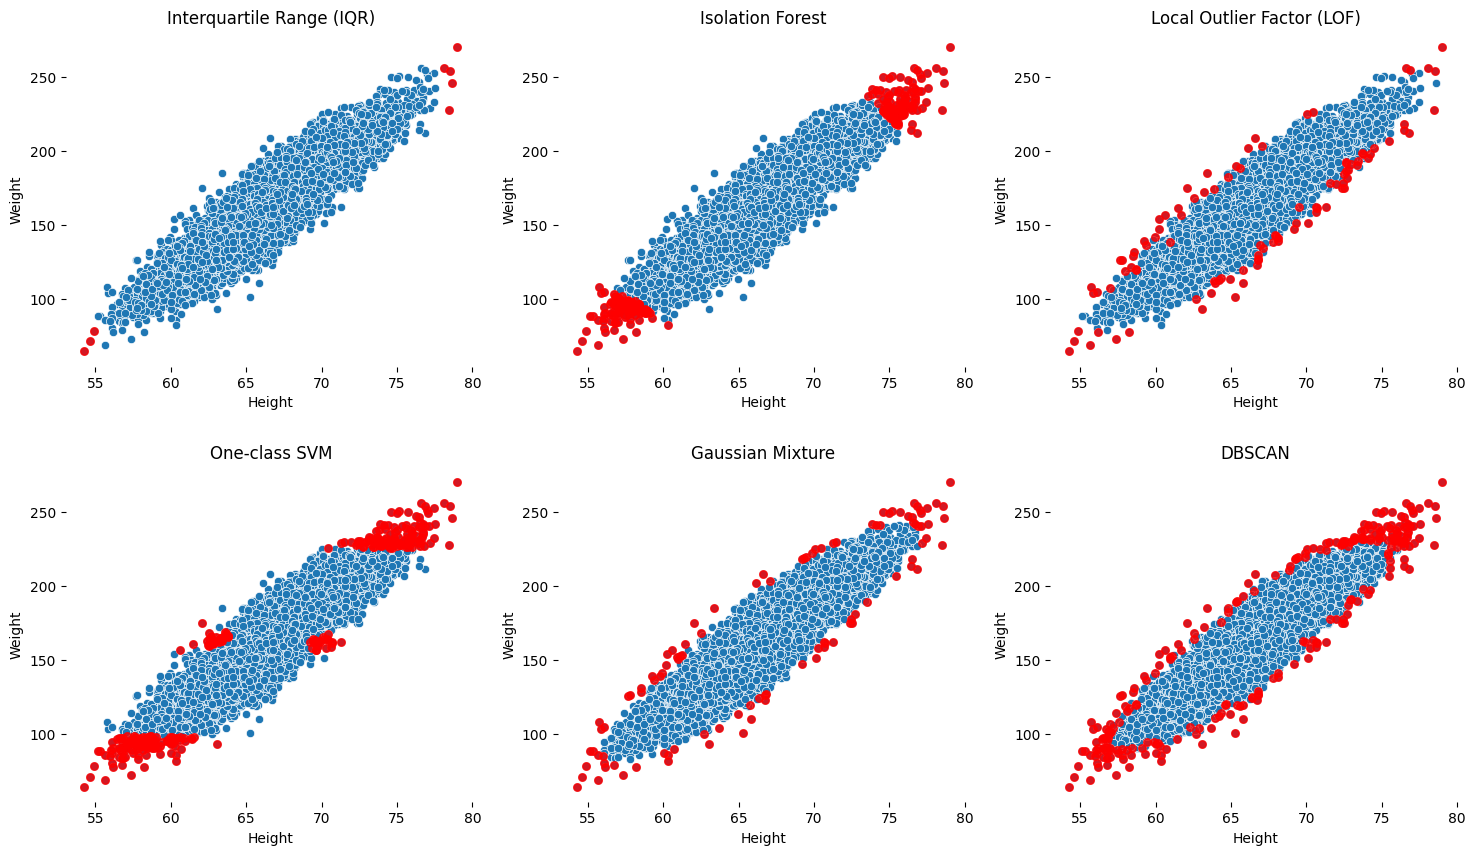

In [8]:
# Выбираем только интересующие нас переменные
data = weight_height[['Height', 'Weight']]

# Функция для отметки аномалий на графике
def mark_anomalies(ax, outliers, color='red'):
    for i in outliers:
        ax.scatter(data.iloc[i]['Height'], data.iloc[i]['Weight'], color=color, s=30, alpha=0.8)

# Параметры графиков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# График 1: Интерквартильный размах (IQR)
ax1 = sns.scatterplot(data=data, x='Height', y='Weight', ax=axes[0, 0])
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers_iqr = ((data < lower_bound) | (data > upper_bound)).any(axis=1)
mark_anomalies(ax1, data[outliers_iqr].index)

ax1.set_title('Interquartile Range (IQR)')
ax1.set_xlabel('Height')
ax1.set_ylabel('Weight')

# График 2: Isolation Forest
ax2 = sns.scatterplot(data=data, x='Height', y='Weight', ax=axes[0, 1])
model_if = IsolationForest(contamination=0.02)
outliers_if = model_if.fit_predict(data)
mark_anomalies(ax2, np.where(outliers_if == -1))

ax2.set_title('Isolation Forest')
ax2.set_xlabel('Height')
ax2.set_ylabel('Weight')

# График 3: Local Outlier Factor (LOF)
ax3 = sns.scatterplot(data=data, x='Height', y='Weight', ax=axes[0, 2])
model_lof = LocalOutlierFactor(contamination=0.01)
outliers_lof = model_lof.fit_predict(data)
mark_anomalies(ax3, np.where(outliers_lof == -1))

ax3.set_title('Local Outlier Factor (LOF)')
ax3.set_xlabel('Height')
ax3.set_ylabel('Weight')

# График 4: One-class SVM
ax4 = sns.scatterplot(data=data, x='Height', y='Weight', ax=axes[1, 0])
model_ocsvm = OneClassSVM(nu=0.03)
outliers_ocsvm = model_ocsvm.fit_predict(data)
mark_anomalies(ax4, np.where(outliers_ocsvm == -1))

ax4.set_title('One-class SVM')
ax4.set_xlabel('Height')
ax4.set_ylabel('Weight')

# График 5: Gaussian Mixture
ax5 = sns.scatterplot(data=data, x='Height', y='Weight', ax=axes[1, 1])
model_gmm = GaussianMixture(n_components=2, covariance_type='full')
model_gmm.fit(data)
probs = model_gmm.score_samples(data)
threshold = -10 # Задание порога для определения выбросов
mark_anomalies(ax5, np.where(probs < threshold))

ax5.set_title('Gaussian Mixture')
ax5.set_xlabel('Height')
ax5.set_ylabel('Weight')

# График 6: DBSCAN
ax6 = sns.scatterplot(data=data, x='Height', y='Weight', ax=axes[1, 2])
model_dbscan = DBSCAN(eps=1, min_samples=10)
outliers_dbscan = model_dbscan.fit_predict(data)
mark_anomalies(ax6, np.where(outliers_dbscan == -1))

ax6.set_title('DBSCAN')
ax6.set_xlabel('Height')
ax6.set_ylabel('Weight')

# Убираем рамки со всех сторон
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()


*Самой адекватной выглядит оценка выбросов Gaussian Mixture (хорошо выделяет ненормальные данные, а данные у нас нормально распределены) и LOF (определяет выбросы по плотности распределения точек, что также хорошо корреклирует с выделением ненормальных данных). DBSCAN тоже хорошо справляется, поскольку также основывается на плотности данных.*

## Задания 2 и 3
Используя датасет, определите оптимальные параметры модели Isolation Forest с помощью кросс-валидации.

In [9]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head(3)

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o


### Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
    Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В GridSearchCV используйте params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
    Сделайте предсказания на данных Х.
    Поиграйте с параметром n_jobs — создайте 6 разных визуализаций с параметрами от 1 до 6.
    Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
    Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).

In [11]:
X = thyroid.drop('Outlier_label ', axis=1)
y = thyroid['Outlier_label ']
y = y.apply(lambda x: -1 if x == 'o' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'n_estimators': list(range(5, 15)), 
          'max_features': list(range(2, 10))}

if_model = IsolationForest(random_state=42)

# Инициализируем GridSearchCV
grid_search = GridSearchCV(if_model, params, scoring='f1', cv=5)
# Обучаем модель с использованием кросс-валидации
grid_search.fit(X_train, y_train)

print("Наилучшие параметры:", grid_search.best_params_)

# Оцениваем модель на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-мера на тестовой выборке:", f1)

Наилучшие параметры: {'max_features': 6, 'n_estimators': 13}
F1-мера на тестовой выборке: 0.967032967032967


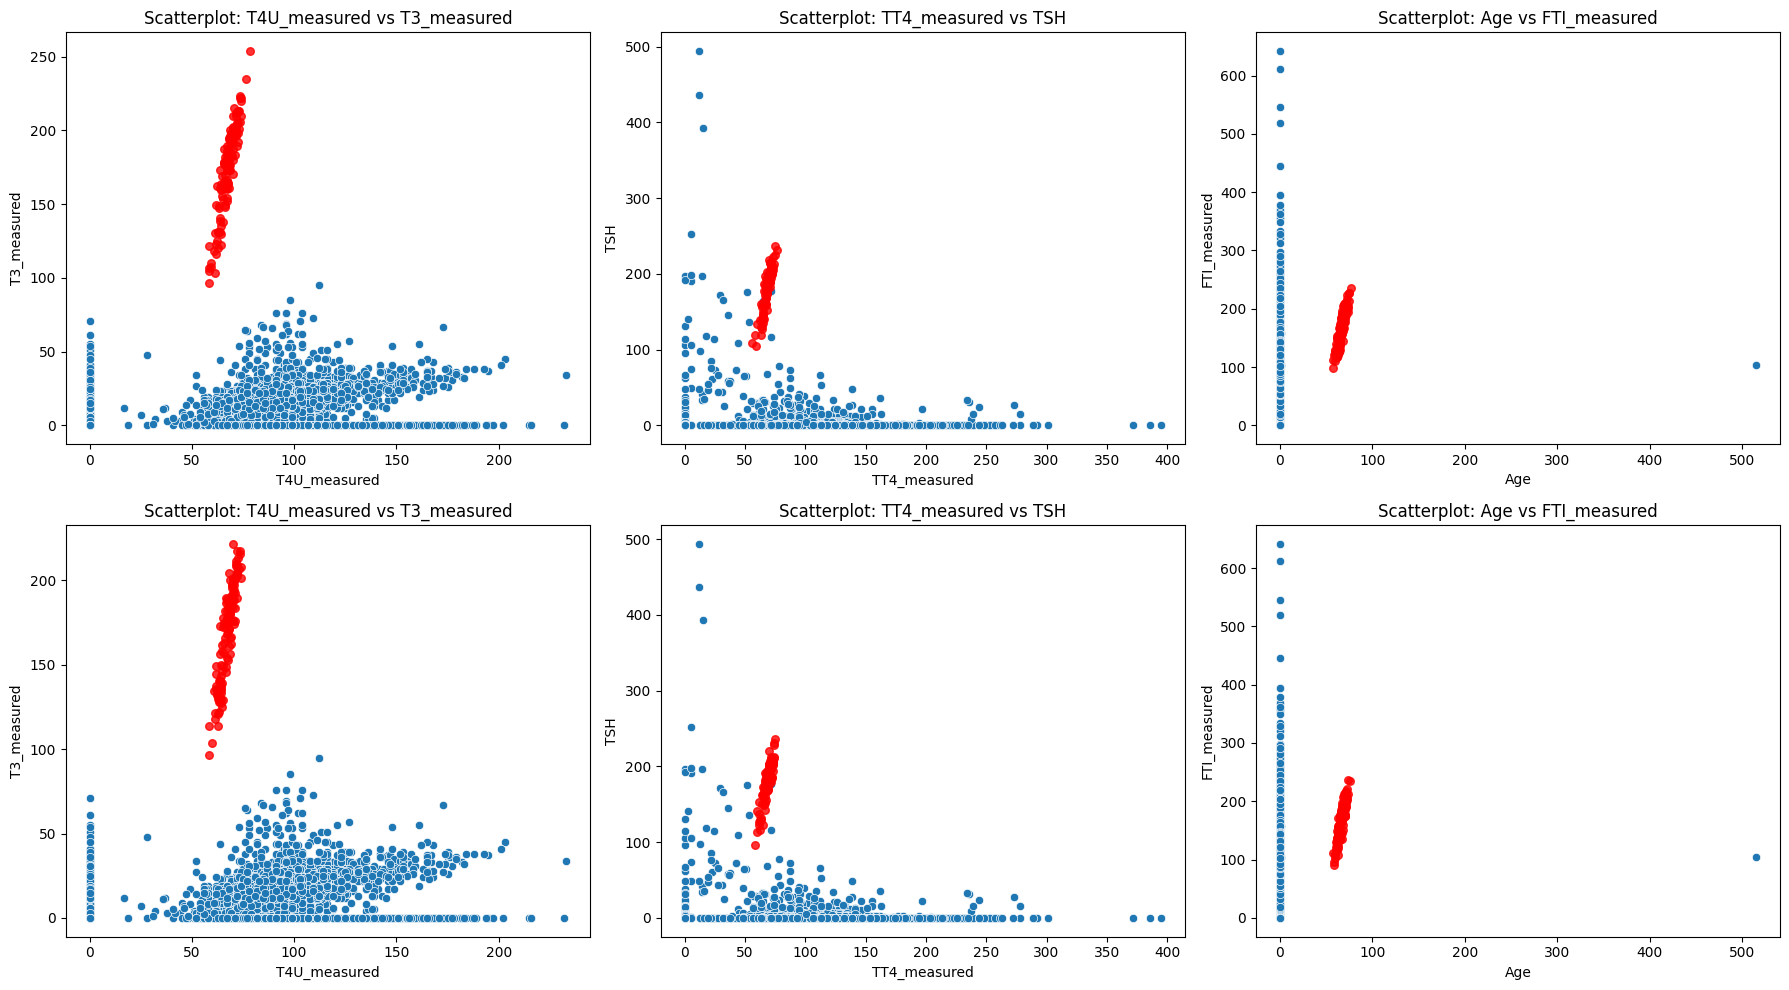

In [83]:
# Поскольку n_jobs не влияет на работу самой модели, только на время (и то в данном случае это будет незаметно) бессмысленно менять этот параметр.
# Построим вместо этого построим визуализации выбросов по разным признакам.

# Выбираем некатегориальные переменные
cols_for_scatter = thyroid.nunique()[thyroid.nunique() > 2].index

# Генерируем все уникальные комбинации пар из cols_for_scatter
all_pairs = list(combinations(cols_for_scatter, 2))

# Выбираем случайные пары признаков из all_pairs
selected_pairs = random.sample(all_pairs, 6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Выбираем случайные пары признаков из cols_for_scatter
selected_pairs = np.random.choice(cols_for_scatter, size=(3, 2), replace=False)

# Итерируемся по подграфикам и строим scatterplot для каждой пары
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        feature_x, feature_y = selected_pairs[j]
        sns.scatterplot(x=feature_x, y=feature_y, data=X, ax=ax)
        ax.set_title(f'Scatterplot: {feature_x} vs {feature_y}')
        model_if = IsolationForest(n_estimators=grid_search.best_params_['n_estimators'], max_samples=grid_search.best_params_['max_features'], contamination=0.02)
        outliers_if = model_if.fit_predict(X)
        mark_anomalies(ax, np.where(outliers_if == -1))

# Размещаем графики на подграфиках
plt.tight_layout()
plt.show()

### Задание 3. Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)
Для каждого Isolation Forest создайте отдельную roc_curve и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.

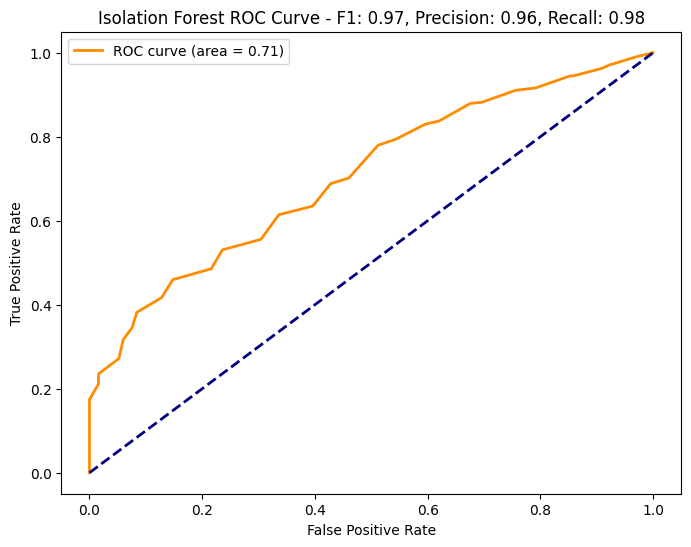

In [165]:
model_if = IsolationForest(n_estimators=grid_search.best_params_['n_estimators'],
                           max_samples=grid_search.best_params_['max_features'],
                           contamination=0.02,
                           random_state=42)
outliers_if = model_if.fit_predict(X)
y_pred_scores = model_if.decision_function(X)

# Вычисляем ROC-кривую и площадь под ней (AUC)
fpr, tpr, thresholds = roc_curve(y, y_pred_scores)
roc_auc = auc(fpr, tpr)

# Визуализируем ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Isolation Forest ROC Curve - F1: {f1:.2f}, Precision: {precision_val:.2f}, Recall: {recall_val:.2f}')
plt.legend()
plt.show()

### Задание 4. Проверка эффективности моделей без учителя (4 балла)
Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (cgpa) и балл за экзамен (placement_exam_marks), а в качестве зависимой переменной в кластеризации используйте переменную placed.

Создайте поле из шести графиков. Каждый график должен представлять собой confusion_matrix (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

    k-Nearest Neighbors (KNN).
    SVM (Support Vector Machine).
    Random Forest.
    AdaBoost.
    Gradient Boosting.
    Decision Tree.

In [3]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head(3)

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1


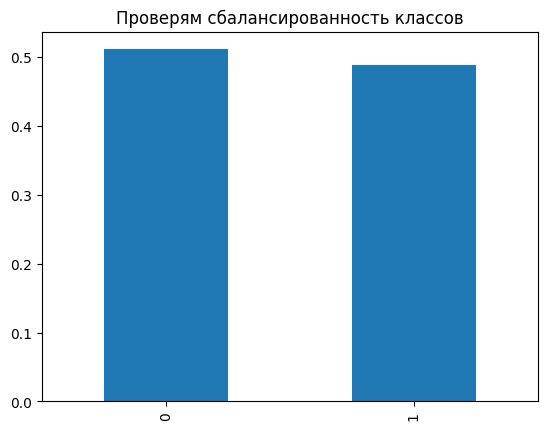

In [16]:
placement['placed'].value_counts(normalize=True).plot(kind='bar')
plt.title('Проверям сбалансированность классов')
plt.show()

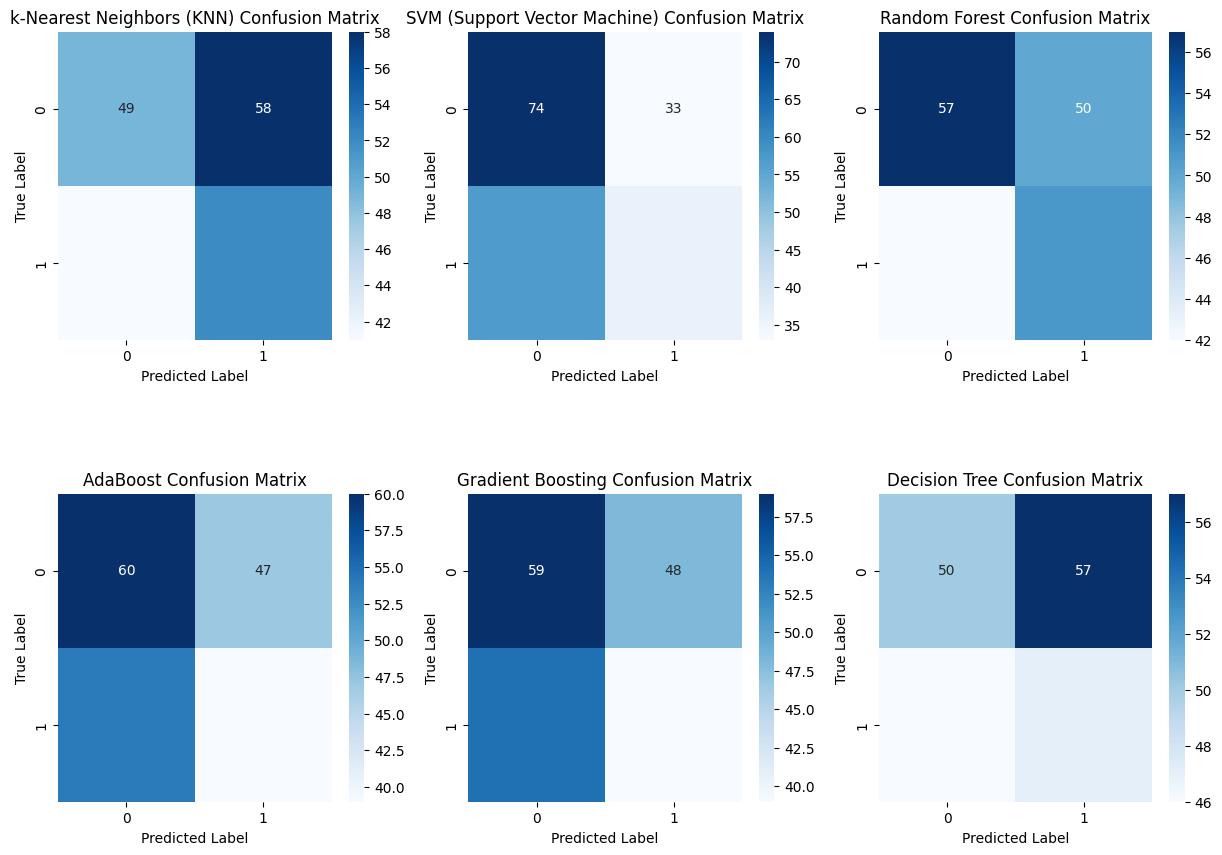

In [7]:
X = placement.drop('placed', axis=1)
y = placement['placed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем список алгоритмов
algorithms = [
    ("k-Nearest Neighbors (KNN)", KNeighborsClassifier()),
    ("SVM (Support Vector Machine)", make_pipeline(StandardScaler(), SVC())),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42))
]

# Создаем поле из 2x3 графиков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Обучаем модели и строим графики
for (name, model), ax in zip(algorithms, axes.flatten()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Строим heatmap с матрицей ошибок
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax)
    
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.show()
